In [51]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
phoneme = fetch_openml(name='phoneme')
X = phoneme.data
y = np.vectorize(lambda x: int(x)-1)(phoneme.target)

In [33]:
X_train,X_test,y_train,y_test = train_test_split(X.values,y,test_size=0.2,random_state=0)

In [34]:
models = {
    "KNN":KNeighborsClassifier(),
    'SVM':SVC(kernel='rbf',random_state=0),
    'Logistic Regression':LogisticRegression(random_state=0)
}

In [35]:
class CrossValidation():
    def __init__(self,features,labels,cv_num):
        self.features = features
        self.labels = labels
        self.cv_num = cv_num
        train = np.hstack((self.features, self.labels.reshape(-1,1)))
        m,n = train.shape
        ratio = 1/self.cv_num
        every_fold_num = int(m*ratio)
        self.train_fold = []
        self.valid_fold = []
        for i in range(self.cv_num):
            valid_data = train[every_fold_num*i:every_fold_num*(i+1)]
            aset = set([tuple(x) for x in train])
            bset = set([tuple(x) for x in valid_data])
            train_data = np.array([x for x in aset-bset])
            self.valid_fold.append(valid_data)
            self.train_fold.append(train_data)     
        self.cur = 0 
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.cur >= len(self.train_fold):
            raise StopIteration
        cur_train_data = self.train_fold[self.cur]
        cur_valid_data = self.valid_fold[self.cur]
        self.cur += 1
        return self.cur, cur_train_data,cur_valid_data

In [47]:
from sklearn.metrics import auc,roc_auc_score,f1_score,accuracy_score,precision_score,recall_score
roc_auc_test = dict()
roc_auc_train = dict()
for name,model in models.items():
    cv = CrossValidation(X_train,y_train,10)
    accuracy_ = list()
    f1_ = list()
    roc_ = list()
    precision_ = list()
    recall_ = list()
    roc_auc_test[name] = list()
    roc_auc_train[name] = list()
    for (cur,train_data,val_data) in cv:
        model.fit(train_data[:,:-1],train_data[:,-1])
        X_val,y_val = val_data[:,:-1],val_data[:,-1]
        roc_auc_train[name].append(roc_auc_score(train_data[:,-1],model.predict(train_data[:,:-1])))
        y_pred = model.predict(X_val)
        accuracy_.append(accuracy_score(y_val,y_pred))
        f1_.append(f1_score(y_val,y_pred))
        roc_.append(roc_auc_score(y_val,y_pred))
        roc_auc_test[name].append(roc_auc_score(y_val,y_pred))
        precision_.append(precision_score(y_val,y_pred))
        recall_.append(recall_score(y_val,y_pred))
    print(f"model--{name},mean_acc={np.mean(accuracy_)},mean_f1={np.mean(f1_)},mean_roc={np.mean(roc_)},mean_precision={np.mean(precision_)},mean_recall={np.mean(recall_)}")

model--KNN,mean_acc=0.8729166666666668,mean_f1=0.7743537247875517,mean_roc=0.8360447970957221,mean_precision=0.804544417166241,mean_recall=0.7478806704265579
model--SVM,mean_acc=0.8412037037037038,mean_f1=0.727885244700518,mean_roc=0.8072826891094402,mean_precision=0.7307579637973175,mean_recall=0.7255730180491871
model--Logistic Regression,mean_acc=0.7537037037037038,mean_f1=0.5279162032280598,mean_roc=0.6713114437199138,mean_precision=0.6013975421994544,mean_recall=0.4715003449585266


In [48]:
import pandas as pd
df1 = pd.DataFrame(roc_auc_train)
df2 = pd.DataFrame(roc_auc_test)

<AxesSubplot:>

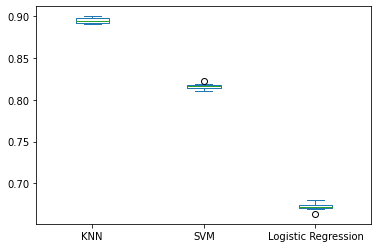

In [49]:
df1.plot.box()

<AxesSubplot:>

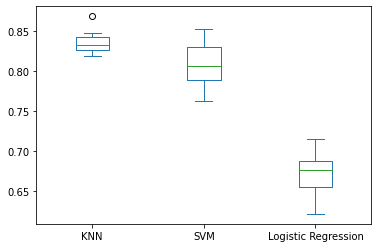

In [50]:
df2.plot.box()

In [70]:
knn_params = {
    'n_neighbors':[4,5,6,7,8]
}
grid_search_knn = GridSearchCV(KNeighborsClassifier(),param_grid=knn_params,scoring='roc_auc',cv=10)

In [71]:
grid_search_knn.fit(X_train,y_train)  
grid_search_knn.cv_results_ 

{'mean_fit_time': array([0.00449991, 0.00417812, 0.00407581, 0.00400753, 0.00400295]),
 'std_fit_time': array([8.23011715e-04, 3.23567007e-04, 1.88403901e-04, 1.70357708e-05,
        2.44232343e-05]),
 'mean_score_time': array([0.00387692, 0.00375042, 0.00388534, 0.00389791, 0.00400012]),
 'std_score_time': array([7.41232941e-04, 4.15327563e-04, 3.07983931e-04, 2.99596487e-04,
        2.09748872e-05]),
 'param_n_neighbors': masked_array(data=[4, 5, 6, 7, 8],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 4},
  {'n_neighbors': 5},
  {'n_neighbors': 6},
  {'n_neighbors': 7},
  {'n_neighbors': 8}],
 'split0_test_score': array([0.90849673, 0.92387165, 0.92762853, 0.92589162, 0.92724255]),
 'split1_test_score': array([0.89915599, 0.90652823, 0.90488138, 0.90980907, 0.90697854]),
 'split2_test_score': array([0.9391951 , 0.94139519, 0.9460527 , 0.94685039, 0.94929494]),
 'split3_test_score': array([0.9185

<AxesSubplot:>

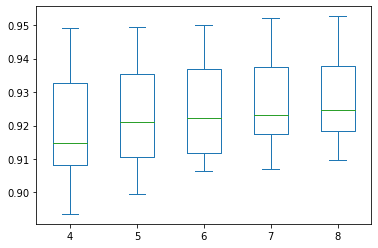

In [92]:
knn_results = list()
for k in grid_search_knn.cv_results_.keys():
    if k.startswith('split'):
        knn_results.append(sorted(grid_search_knn.cv_results_[k]))
knn_results = np.array(knn_results)
pd.DataFrame(knn_results,columns=['4','5','6','7','8']).plot.box()

In [72]:
grid_search_knn.best_params_

{'n_neighbors': 8}

In [73]:
grid_search_knn.best_score_ 

0.9277155130466721

In [76]:
svm_params = {
    'kernel':['rbf','poly']
}
grid_search_svm = GridSearchCV(SVC(random_state=0),param_grid=svm_params,scoring='roc_auc',cv=10)

In [77]:
grid_search_svm.fit(X_train,y_train)  
grid_search_svm.cv_results_ 

{'mean_fit_time': array([0.1873306 , 0.25095394]),
 'std_fit_time': array([0.00407087, 0.01120929]),
 'mean_score_time': array([0.05529428, 0.013433  ]),
 'std_score_time': array([0.00258337, 0.00036767]),
 'param_kernel': masked_array(data=['rbf', 'poly'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'kernel': 'rbf'}, {'kernel': 'poly'}],
 'split0_test_score': array([0.90739025, 0.83256137]),
 'split1_test_score': array([0.88816839, 0.82630848]),
 'split2_test_score': array([0.92527405, 0.85914261]),
 'split3_test_score': array([0.88240481, 0.83605664]),
 'split4_test_score': array([0.88940761, 0.8345264 ]),
 'split5_test_score': array([0.92110494, 0.85256228]),
 'split6_test_score': array([0.90365303, 0.82411256]),
 'split7_test_score': array([0.91922034, 0.85540209]),
 'split8_test_score': array([0.92761069, 0.87195043]),
 'split9_test_score': array([0.89817994, 0.82256357]),
 'mean_test_score': array([0.90624141, 0.84151864]),


<AxesSubplot:>

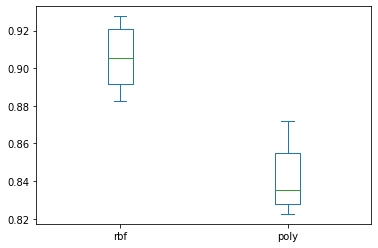

In [89]:
svm_results = list()
for k in grid_search_svm.cv_results_.keys():
    if k.startswith('split'):
        svm_results.append(grid_search_svm.cv_results_[k])
svm_results = np.array(svm_results)
pd.DataFrame(svm_results,columns=['rbf','poly']).plot.box()

In [90]:
grid_search_svm.best_params_

{'kernel': 'rbf'}

In [91]:
grid_search_svm.best_score_ 

0.9062414061523141